In [1]:
import os

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import shapely.geometry
from scipy.misc import imresize
import pickle

%matplotlib inline

In [2]:
with open('mn_xtrain_256_rgb_man.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('mn_ytrain_256_man.pkl', 'rb') as f:
    Y_train = pickle.load(f)

with open('mn_xval_256_rgb_man.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open('mn_yval_256_man.pkl', 'rb') as f:
    Y_val = pickle.load(f)

In [5]:
# Load the image summary
image_summary = gpd.read_file('vectors/shanghai_RGB_image_summary.geojson')

# Load the landuse data from OSM
osm_landuse = gpd.read_file('vectors/shanghai_landuse.geojson')

# Convert everything to polygons
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)

# Limit to just farmland
farmland = osm_landuse[osm_landuse.landuse == 'farmland'].unary_union

# Background
farmyard = osm_landuse[osm_landuse.landuse == 'farmyard'].unary_union
industrial = osm_landuse[osm_landuse.landuse == 'industrial'].unary_union

vectors = [farmland, farmyard, industrial]

In [32]:
farmland;

In [33]:
farmyard;

In [3]:
INPUT_SIZE = 256

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []
    
def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def scale_bands(img, lower_pct=1, upper_pct=99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized



In [78]:
X_train.shape

(3972, 256, 256, 3)

In [4]:
# flake8: noqa
# -*- coding: utf-8 -*-
"""ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
Adapted from Keras.
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import (
    decode_predictions, preprocess_input, _obtain_input_shape)


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    act_name = 'act' + str(stage)+ block

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu', name=act_name)(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    act_name = 'act' + str(stage) + block

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu', name=act_name)(x)
    return x


Using TensorFlow backend.


In [9]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras import applications
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Lambda, Add, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
import keras.backend.tensorflow_backend
# if keras.backend.tensorflow_backend._SESSION:
#     tf.reset_default_graph() 
#     keras.backend.tensorflow_backend._SESSION.close()
#     keras.backend.tensorflow_backend._SESSION = None
K.clear_session()
# Set network size params
N_CLASSES = 1
N_CHANNEL = 3
#IMG_DIM = 640

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def depth_softmax(matrix):
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
    return softmax_matrix


#base_model = ResNet50(weights = None, include_top=False, input_shape=(240, 240, 3), input_tensor=input_tensor)

# Freeze layers don't want trained
#     for layer in base_model.layers[:3]:
#         layer.trainable = False
def fcn_model(lr=.001):
    K.clear_session()
    
    input_shape = (INPUT_SIZE, INPUT_SIZE, N_CHANNEL)
    
    weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
    bn_axis = 3
    img_input = Input(shape=input_shape)
    
    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    c3 = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(c3, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    c4 = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(c4, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    c5 = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
#     conv_p1 = Conv2D(2048, (7, 7), strides=(1, 1), padding='valid', kernel_initializer='he_normal')(c5)
#     drop_p1 = Dropout(0.5)(conv_p1)
    conv_p1 = Conv2D(2048, (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal')(c5)
    drop_p1 = Dropout(0.5)(conv_p1)
    
    score_c5 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(drop_p1)
    up_c5 = Conv2DTranspose(N_CLASSES, (2, 2), strides=(2, 2), padding='valid')(score_c5)
    
    score_c4 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(c4)
    fuse_16 = Add()([score_c4, up_c5])
    up_c4 = Conv2DTranspose(N_CLASSES, (2, 2), strides=(2, 2), padding='valid')(fuse_16)
    
    score_c3 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(c3)
    fuse_32 = Add()([score_c3, up_c4])
    up_c3 = Conv2DTranspose(N_CLASSES, (8, 8), strides=(8, 8), padding='valid', activation='sigmoid')(fuse_32)



    #fcn_model = Sequential()
    fcn_model = Model(inputs=img_input, outputs=up_c3)
    
    fcn_model.load_weights(weights_path, by_name=True)
    #fcn_model.load_weights('fcn_resnet_20epoch_weights.h5', by_name=False)
    
    fcn_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef])
    
    return fcn_model











In [7]:
lr = 0.001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
              patience=3, min_lr=0.000001)

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints', 'weights.{epoch:02d}-{loss:.5f}.hdf5'),
                                  monitor='loss', save_best_only=True)


NUM_EPOCHS = 20
# gen = ImageDataGenerator()
# train_batches = gen.flow(X_train, Y_train)
# tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)
STEPS_PER_EPOCH = X_train.shape[0] / 32
VALIDATION_STEPS = len(X_val) / 32
INPUT_SIZE = 256


model = fcn_model(lr=.0001)
#model.fit_generator(train_batches, steps_per_epoch=STEPS_PER_EPOCH, epochs=NUM_EPOCHS, verbose=1, callbacks=[reduce_lr])
model.fit(X_train, Y_train, batch_size=12, epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_data=(X_val, Y_val),
         callbacks=[reduce_lr, model_checkpoint])


Train on 3608 samples, validate on 531 samples
Epoch 1/20
3608/3608 [==============================] - 212s - loss: 0.6703 - jacc_coef: 0.0542 - val_loss: 0.6346 - val_jacc_coef: 0.0461
Epoch 2/20
3608/3608 [==============================] - 186s - loss: 0.5754 - jacc_coef: 0.0576 - val_loss: 0.5242 - val_jacc_coef: 0.0430
Epoch 3/20
3608/3608 [==============================] - 186s - loss: 0.4422 - jacc_coef: 0.0673 - val_loss: 0.3763 - val_jacc_coef: 0.0529
Epoch 4/20
3608/3608 [==============================] - 186s - loss: 0.2990 - jacc_coef: 0.0860 - val_loss: 0.2367 - val_jacc_coef: 0.0745
Epoch 5/20
3608/3608 [==============================] - 186s - loss: 0.1843 - jacc_coef: 0.1217 - val_loss: 0.1782 - val_jacc_coef: 0.1103
Epoch 6/20
3608/3608 [==============================] - 186s - loss: 0.1310 - jacc_coef: 0.1614 - val_loss: 0.1339 - val_jacc_coef: 0.1371
Epoch 7/20
3608/3608 [==============================] - 186s - loss: 0.1109 - jacc_coef: 0.1858 - val_loss: 0.1200 - va

In [89]:
model.save_weights('fcn_resnet_40epoch_weights.h5')

In [90]:
model.save('cn_resnet_40epoch_model.h5')

In [10]:
model = fcn_model()
model.load_weights(os.path.join('checkpoints','weights.18-0.03013.hdf5'))

In [11]:
import time
import IPython.display as display

In [18]:
# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
# model = get_unet()
# model.load_weights('checkpoints/weights.50-0.08328.hdf5')

# Pick out which target to look at
CLASS_NO = 0

# Pick an image with some positive pixels in the target
usable_imgs = []
for i in range(Y_val.shape[0]):
    if Y_val[i, :, :, CLASS_NO].sum() > 1000:
        usable_imgs.append(i)
print("Found %d usable images in the validation set."%len(usable_imgs))

for i in range(200, Y_val.shape[0]):
    X = X_val[i]
    Y = Y_val[i]

    targ = Y[:, :, CLASS_NO]

    # Run the model on that sample
    pred = model.predict(X[None, ...])[0, :, :, CLASS_NO] > 0.15

    # Plot it
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
    ax1.imshow(scale_bands(X[:, :, [2,1,0]])) # This index starts at 0, so I had to decrement
    ax2.imshow(targ, vmin=0, vmax=1)
    ax3.imshow(pred, vmin=0, vmax=1)

    ax1.set_title('Image, ' + str(i))
    ax2.set_title('Ground Truth')
    ax3.set_title('Prediction')
    plt.show()
    
    time.sleep(1)
    display.clear_output(wait=True)

print('DONE')245, 276, 282, 287, 329, 398, 422

DONE


In [46]:
for x in X_train:
    if np.array_equal(x, X_val[276]):
        print('yes')

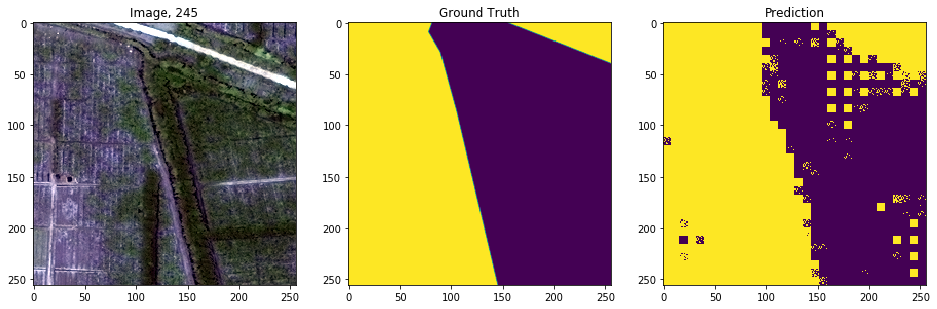

In [53]:
i = 245
X = X_val[i]
Y = Y_val[i]

targ = Y[:, :, CLASS_NO]

# Run the model on that sample
pred = model.predict(X[None, ...])[0, :, :, CLASS_NO] > 0.15

# Plot it
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,8))
ax1.imshow(scale_bands(X[:, :, [2,1,0]])) # This index starts at 0, so I had to decrement
ax2.imshow(targ, vmin=0, vmax=1)
ax3.imshow(pred, vmin=0, vmax=1)

ax1.set_title('Image, ' + str(i))
ax2.set_title('Ground Truth')
ax3.set_title('Prediction')
